In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [2]:
dataset = 'cityscapes'
annot_dir = './cityscapes/annotations'
imgs_dir = './cityscapes'

for split in ['train', 'val']: 
    if split == 'train':
        annot_path = os.path.join(annot_dir, f'instancesonly_filtered_gtFine_{split}_temp.json')
    else:
        annot_path = os.path.join(annot_dir, f'instancesonly_filtered_gtFine_{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

# Load dataset
dataset_dicts = DatasetCatalog.get('cityscapes_train')
metadata = MetadataCatalog.get('cityscapes_train')

[03/26 18:20:30 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./cityscapes/annotations/instancesonly_filtered_gtFine_train_temp.json


In [3]:
#ln -s /Users/giakhang/Downloads/output_yolof_uni_matcher ./

In [4]:
import argparse

class Args(argparse.Namespace):
    config_file='yolof_mask/configs/yolof/yolof_resnet_50_1x.py'
    eval_only=False
    num_gpus=1
    num_machines=1
    resume=False

args = Args()

In [5]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate


cfg = LazyConfig.load("yolof_mask/configs/yolof/yolof_resnet_50_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'cityscapes_train'
cfg.dataloader.train.dataset.names = 'cityscapes_train'
cfg.dataloader.test.dataset.names = 'cityscapes_val'
cfg.dataloader.train.total_batch_size = 1
cfg.dataloader.train.mapper.use_instance_mask = True

cfg.model.num_classes = 9
cfg.model.nms_thresh_test = 0.4

In [6]:
yolof = instantiate(cfg.model)
yolof.to(cfg.train.device)

YOLOF(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): BottleneckBlock(
        (

In [7]:
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(yolof).load('./output_yolof_uni_matcher/model_final.pth')

[03/26 18:20:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_yolof_uni_matcher/model_final.pth ...


{'trainer': {'iteration': 22499,
  'hooks': {'LRScheduler': {'base_lrs': [0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.002505,
     0.03,
     0.0075,
     0.03,
     0.03,
     0.03,
     0.0075,
     0.03,
     0.03,
     0.03,
     0.0075,
     0.03,
     0.03,
     0.03,
     0.0075,
     0.03,
     0.03,
     0.03,
     0.0075,
     0.03,
     0.03,
     0.03,
     0.0075,
     0.03,
     0.03,
     0.03,
     0.0075,
 

In [8]:
dataloader = instantiate(cfg.dataloader.train)

[03/26 18:20:43 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./cityscapes/annotations/instancesonly_filtered_gtFine_train_temp.json
[03/26 18:20:43 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[03/26 18:20:43 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   person   | 14           |    car     | 9            |   truck    | 0            |
|   rider    | 0            | motorcycle | 0            |  bicycle   | 4            |
|    bus     | 2            |   train    | 0            |            |              |
|   total    | 29           |            |              |            |              |
[03/26 18:20:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=[800], max_size=1333, sample_style='

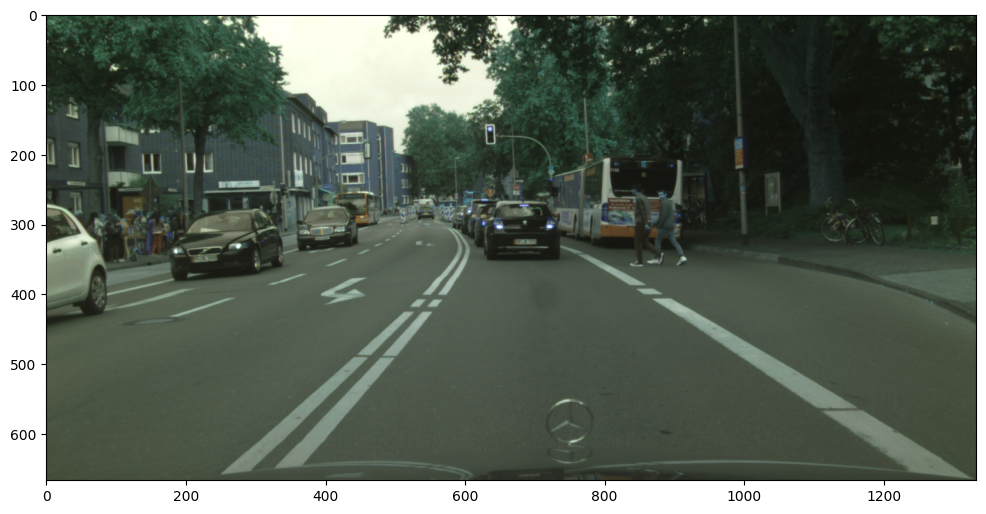

In [9]:
# show image
batch = next(iter(dataloader))
img = batch[0]['image']
img = np.ascontiguousarray(img.permute(1, 2, 0), dtype=np.uint8)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.imshow(img)

In [10]:
batch[0]['image'].shape

torch.Size([3, 667, 1333])

In [11]:
batch[0]

{'file_name': './cityscapes/leftImg8bit/val/munster/munster_000032_000019_leftImg8bit.png',
 'height': 1024,
 'width': 2048,
 'image_id': 2975,
 'image': tensor([[[ 62,  56,  51,  ...,  29,  26,  27],
          [ 72,  66,  55,  ...,  32,  31,  32],
          [ 74,  62,  52,  ...,  32,  31,  32],
          ...,
          [ 69,  68,  68,  ...,  66,  63,  62],
          [ 69,  68,  68,  ...,  71,  66,  61],
          [ 69,  68,  68,  ...,  66,  65,  62]],
 
         [[104,  94,  82,  ...,  36,  31,  33],
          [113, 103,  85,  ...,  39,  36,  38],
          [113,  99,  84,  ...,  41,  38,  39],
          ...,
          [ 77,  77,  77,  ...,  76,  71,  68],
          [ 78,  77,  77,  ...,  79,  73,  67],
          [ 78,  77,  77,  ...,  71,  71,  68]],
 
         [[ 78,  65,  57,  ...,  27,  23,  22],
          [ 88,  75,  60,  ...,  30,  28,  29],
          [ 87,  72,  60,  ...,  32,  27,  27],
          ...,
          [ 59,  59,  59,  ...,  60,  56,  52],
          [ 60,  59,  59,  .

In [12]:
yolof.training = False
output = yolof(batch)

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
# Plot output
output = output[0]

In [14]:
output

{'instances': Instances(num_instances=22, image_height=1024, image_width=2048, fields=[pred_boxes: Boxes(tensor([[ 256.7438,  420.5787,  541.3996,  591.0424],
         [ 542.3719,  414.3698,  708.1733,  522.3274],
         [ 954.4710,  404.1778, 1133.8922,  547.5623],
         [1336.0522,  381.0608, 1411.5240,  558.9227],
         [ 820.0049,  410.5393,  866.4832,  455.1890],
         [1299.7057,  360.1023, 1385.2087,  567.1960],
         [   8.8060,  405.2029,  156.1670,  681.1689],
         [1682.1176,  361.4785, 1851.6863,  520.1339],
         [ 775.8480,  411.1787,  826.2031,  452.0080],
         [ 628.2657,  391.7683,  724.5505,  467.8424],
         [ 923.3341,  399.9124, 1036.3660,  512.9600],
         [   5.3456,  394.7368,  158.6144,  684.7791],
         [ 873.3887,  421.3729,  922.0363,  466.3280],
         [ 227.6311,  439.9548,  284.6694,  544.2045],
         [ 180.6878,  440.4854,  280.0828,  545.5770],
         [ 976.5362,  399.7448, 1052.9961,  495.6474],
         [ 629.1

In [15]:
img.shape

(667, 1333, 3)

In [16]:
filter_mask = output['instances'].scores > 0.75

In [17]:
boxes = output['instances'].pred_boxes[filter_mask].tensor.to('cpu')
classes = output['instances'].pred_classes[filter_mask].to('cpu')

In [18]:
import torch
import numpy as np

boxes = boxes.to(torch.int32).numpy()
classes

tensor([7, 7, 7, 8, 7])

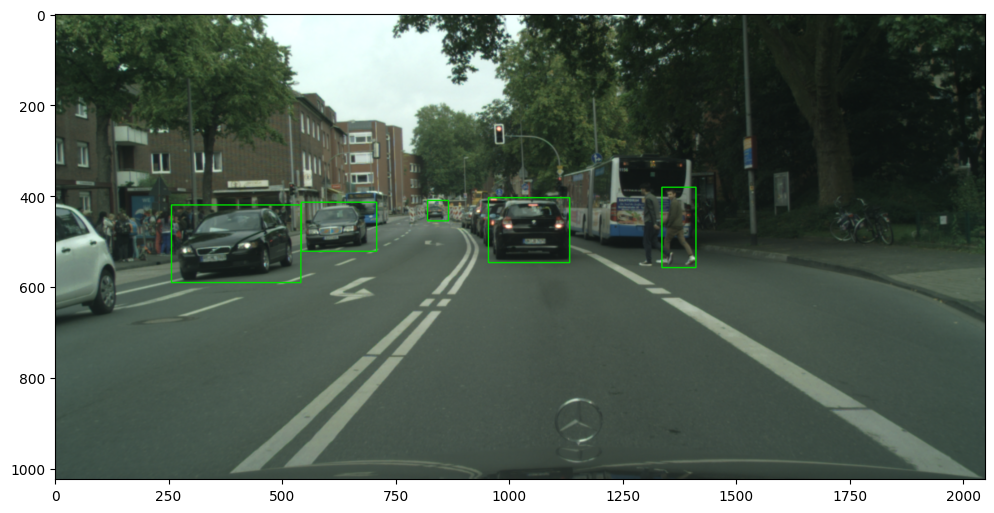

In [19]:
img = batch[0]['image'].permute(1, 2, 0).numpy()
img = np.ascontiguousarray(img)

h_w = output['instances'].image_size
img = cv2.resize(img, h_w[::-1])

for box in boxes:
    img = cv2.rectangle(img, box[:2], box[2:], (0, 225, 0), 2)
    #print(box[:2], box[2:])

_ = plt.figure(figsize=(12, 10))
plt.imshow(img[..., ::-1])

# Input size in the entire pipeline

In [18]:
images = yolof.preprocess_image(batch)

print('Original image size: {} x {}'.format(batch[0]['width'], batch[0]['height']))
print('Image size in dataloader: {} x {}'.format(images.image_sizes[0][1], images.image_sizes[0][0]))
print('Image size after preprocessing (preparing to feed to model): {} x {}'.format(images.tensor.size(-1), images.tensor.size(-2)))

Original image size: 2048 x 1024
Image size in dataloader: 1333 x 667
Image size after preprocessing (preparing to feed to model): 1333 x 667


In [19]:
images = yolof.preprocess_image(batch)

print('Image size after preprocessing (preparing to feed to model): {} x {}'.format(images.tensor.size(-1), images.tensor.size(-2)))

Image size after preprocessing (preparing to feed to model): 1333 x 667


In [20]:
features = yolof.backbone(images.tensor)
features = features['res5']

print('Feature maps size after feeding to backbone (s = s/32): {} x {}'.format(features.size(-1), features.size(-2)))

Feature maps size after feeding to backbone (s = s/32): 42 x 21


In [21]:
box_cls, box_delta = yolof.decoder(yolof.encoder(features))
anchors = yolof.anchor_generator([features])

print('Box class size: {} x {}'.format(box_cls.size(-1), box_cls.size(-2)))
print('Box delta size: {} x {}'.format(box_delta.size(-1), box_delta.size(-2)))
print('Anchors shape: {} x {}'.format(anchors[0][0].tensor.size(-1), anchors[0][0].tensor.size(0)))

assert anchors[0][0].tensor.size(0) == 5 * box_cls.size(-1) * box_cls.size(-2)

Box class size: 42 x 21
Box delta size: 42 x 21
Anchors shape: 4 x 4410


In [22]:
results = yolof.inference([box_cls], [box_delta], anchors, images.image_sizes)
result = results[0]

print('Prediction on image has shape (this shape is the shape before preprocessing): {} x {}'.format(*result.image_size[::-1]))

Prediction on image has shape (this shape is the shape before preprocessing): 1333 x 667


Result image size: 1333 x 667
Image size at this stage: 1333 x 667


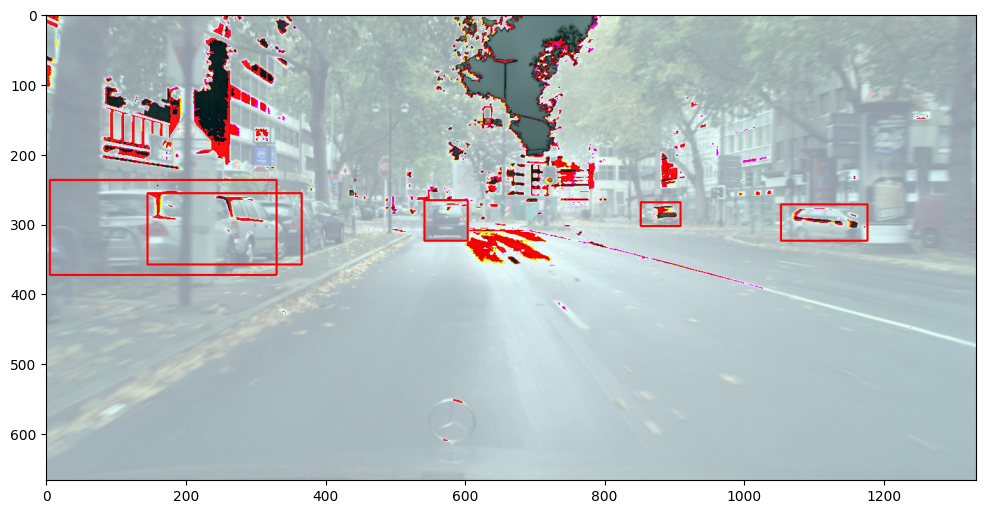

In [23]:
img_tmp = images.tensor[0].to(torch.uint8).permute(1, 2, 0).to('cpu').numpy().copy()

for box in result.pred_boxes[:5]:
    box = box.to('cpu').to(torch.int32).numpy()
    img_tmp = cv2.rectangle(img_tmp, box[:2], box[2:], (0, 0, 255), 2)

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_tmp[..., ::-1])

print('Result image size: {} x {}'.format(*result.image_size[::-1]))
print('Image size at this stage: {} x {}'.format(*img_tmp.shape[:2][::-1]))

In [24]:
from detectron2.modeling.postprocessing import detector_postprocess

processed_results = []

for results_per_image, input_per_image, image_size in zip(
    results, batch, images.image_sizes):
    height = input_per_image.get('height', image_size[0])
    width = input_per_image.get('width', image_size[1])
    
    r = detector_postprocess(results_per_image, height, width)
    processed_results.append({'instances': r})

Processed result image size: 2048 x 1024
Image size after post-processing: 2048 x 1024


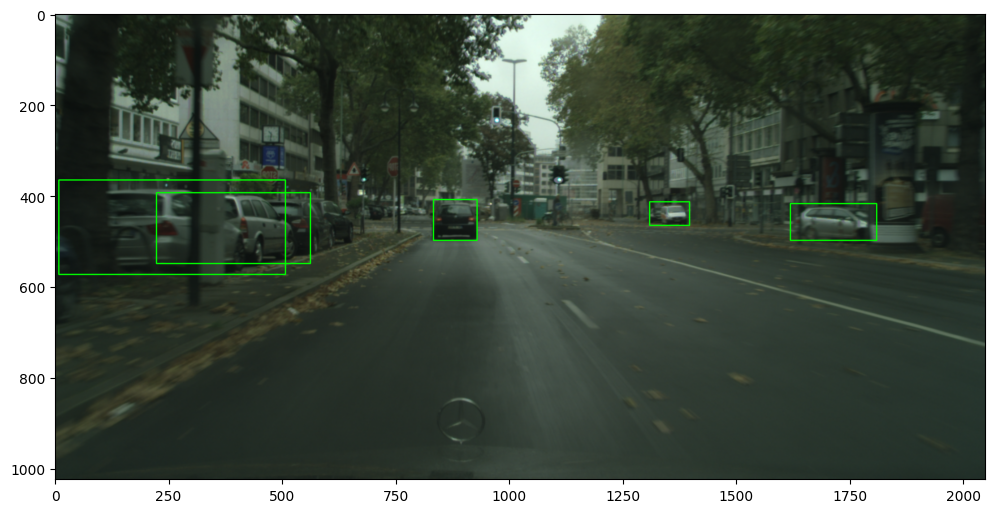

In [25]:
processed_result = processed_results[0]['instances']

img_size = processed_result.image_size

raw_img = batch[0]['image'].to(torch.uint8).permute(1, 2, 0).to('cpu').numpy().copy()
raw_img = cv2.resize(raw_img, img_size[::-1])

for box in processed_result.pred_boxes[:5]:
    box = box.to('cpu').to(torch.int32).numpy()
    raw_img = cv2.rectangle(raw_img, box[:2], box[2:], (0, 255, 0), 2)

fig = plt.figure(figsize=(12, 12))
plt.imshow(raw_img[..., ::-1])

print('Processed result image size: {} x {}'.format(*img_size[::-1]))
print('Image size after post-processing: {} x {}'.format(*raw_img.shape[:2][::-1]))

# Simulate inference stage 

In [27]:
images = yolof.preprocess_image(batch)
features = yolof.backbone(images.tensor)
features = features['res5']
box_cls, box_delta = yolof.decoder(yolof.encoder(features))
anchors = yolof.anchor_generator([features])
results = yolof.inference([box_cls], [box_delta], anchors, images.image_sizes)

In [28]:
images.image_sizes

[(402, 1333)]

In [29]:
features.shape

torch.Size([1, 2048, 13, 42])

In [30]:
results

[Instances(num_instances=8, image_height=402, image_width=1333, fields=[pred_boxes: Boxes(tensor([[406.2224, 193.8669, 464.0215, 225.5355],
         [589.9467, 181.8413, 766.7061, 350.3064],
         [323.5023, 186.2306, 348.2942, 221.2933],
         [530.9360, 177.4620, 553.7035, 188.1650],
         [565.8536, 168.3945, 587.0291, 186.7894],
         [526.6335, 169.7064, 559.8585, 186.5175],
         [522.2622, 173.1471, 563.5007, 190.2981],
         [324.6994, 186.5236, 350.8427, 222.2042]], device='mps:0',
        grad_fn=<IndexBackward0>)), scores: tensor([0.9661, 0.9293, 0.9105, 0.8441, 0.3992, 0.2076, 0.0964, 0.0759],
        device='mps:0', grad_fn=<IndexBackward0>), pred_classes: tensor([7, 7, 0, 1, 1, 1, 1, 1], device='mps:0')])]

## These lines above are viewed as ROI proposals

In [31]:
from detectron2.modeling.poolers import ROIPooler

In [32]:
pooler = ROIPooler(output_size=14, scales=(1.0/32,), sampling_ratio=0, pooler_type='ROIAlignV2')

In [33]:
proposal_boxes = [x.pred_boxes for x in results]

In [34]:
features = [features]

In [54]:
roi_maps = pooler(features, proposal_boxes)

In [55]:
roi_maps.shape

torch.Size([8, 2048, 14, 14])

In [56]:
roi_maps.device

device(type='mps', index=0)

In [57]:
from detectron2.modeling.roi_heads import MaskRCNNConvUpsampleHead
from detectron2.layers import ShapeSpec

In [99]:
mask_head = MaskRCNNConvUpsampleHead(input_shape=ShapeSpec(channels=2048, width=14, height=14),
                                     num_classes=9,
                                     conv_dims=[256])

In [100]:
mask_head

MaskRCNNConvUpsampleHead(
  (deconv): ConvTranspose2d(2048, 256, kernel_size=(2, 2), stride=(2, 2))
  (deconv_relu): ReLU()
  (predictor): Conv2d(256, 9, kernel_size=(1, 1), stride=(1, 1))
)

In [101]:
mask_head.to('mps')

MaskRCNNConvUpsampleHead(
  (deconv): ConvTranspose2d(2048, 256, kernel_size=(2, 2), stride=(2, 2))
  (deconv_relu): ReLU()
  (predictor): Conv2d(256, 9, kernel_size=(1, 1), stride=(1, 1))
)

In [102]:
x = mask_head.layers(roi_maps)

In [103]:
x.shape

torch.Size([8, 9, 28, 28])

# Simulate training stage

In [46]:
images = yolof.preprocess_image(batch)
features = yolof.backbone(images.tensor)
features = features['res5']
box_cls, box_delta = yolof.decoder(yolof.encoder(features))
anchors = yolof.anchor_generator([features])
proposals = yolof.inference([box_cls], [box_delta], anchors, images.image_sizes)

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [47]:
# Do we need to label_and_sample_proposals????

In [48]:
from detectron2.modeling.roi_heads import MaskRCNNConvUpsampleHead
from detectron2.layers import ShapeSpec

mask_head = MaskRCNNConvUpsampleHead(input_shape=ShapeSpec(channels=2048, width=14, height=14),
                                     num_classes=9,
                                     conv_dims=[256])
mask_head.to('mps')

MaskRCNNConvUpsampleHead(
  (deconv): ConvTranspose2d(2048, 256, kernel_size=(2, 2), stride=(2, 2))
  (deconv_relu): ReLU()
  (predictor): Conv2d(256, 9, kernel_size=(1, 1), stride=(1, 1))
)

In [49]:
from detectron2.modeling.poolers import ROIPooler

pooler = ROIPooler(output_size=14, scales=(1.0/32,), sampling_ratio=0, pooler_type='ROIAlignV2')
pooler.to('mps')

ROIPooler(
  (level_poolers): ModuleList(
    (0): ROIAlign(output_size=(14, 14), spatial_scale=0.03125, sampling_ratio=0, aligned=True)
  )
)

In [50]:
proposal_boxes = [x.pred_boxes.to('mps') for x in proposals]
box_features = pooler([features], proposal_boxes)
pred_mask_logits = mask_head.layers(box_features)

In [51]:
gt_instances = [x['instances'] for x in batch]

In [52]:
gt_masks = []

for instances_per_image in gt_instances:
    gt_masks_per_image = instances_per_image.gt_masks.crop_and_resize(
        instances_per_image.gt_boxes.tensor, 14)
    gt_masks.append(gt_masks_per_image.to(device='mps'))

In [53]:
gt_masks_per_image = gt_masks[0].to('cpu')

In [64]:
gt_masks_per_image.shape

torch.Size([5, 14, 14])

# Append to gt

In [39]:
filter_mask = output['instances'].scores > 0.75
boxes = output['instances'].pred_boxes[filter_mask].tensor.to('cpu')
classes = output['instances'].pred_classes[filter_mask].to('cpu')
scores = output['instances'].scores[filter_mask].to('cpu')

In [40]:
boxes

tensor([[ 256.7438,  420.5787,  541.3996,  591.0424],
        [ 542.3719,  414.3698,  708.1733,  522.3274],
        [ 954.4710,  404.1778, 1133.8922,  547.5623],
        [1336.0522,  381.0608, 1411.5240,  558.9227],
        [ 820.0049,  410.5393,  866.4832,  455.1890]],
       grad_fn=<ToCopyBackward0>)

In [41]:
classes

tensor([7, 7, 7, 8, 7])

In [30]:
gt_instance = batch[0]['instances']

In [31]:
from detectron2.structures import Instances

gt_proposal = Instances(gt_instance.image_size, **gt_instance.get_fields())

In [32]:
gt_proposal.pred_boxes = boxes

AssertionError: Adding a field of length 5 to a Instances of length 29

In [34]:
gt_proposal = gt_proposal[:len(boxes)]

In [42]:
gt_proposal.pred_boxes = boxes
gt_proposal.scores = scores
gt_proposal.pred_classes = classes

In [43]:
gt_proposal

Instances(num_instances=5, image_height=667, image_width=1333, fields=[gt_boxes: Boxes(tensor([[490., 274., 495., 288.],
        [482., 276., 490., 289.],
        [319., 276., 335., 304.],
        [315., 280., 325., 292.],
        [305., 274., 311., 280.]])), gt_classes: tensor([0, 0, 0, 0, 0]), gt_masks: PolygonMasks(num_instances=5), pred_boxes: tensor([[ 256.7438,  420.5787,  541.3996,  591.0424],
        [ 542.3719,  414.3698,  708.1733,  522.3274],
        [ 954.4710,  404.1778, 1133.8922,  547.5623],
        [1336.0522,  381.0608, 1411.5240,  558.9227],
        [ 820.0049,  410.5393,  866.4832,  455.1890]],
       grad_fn=<ToCopyBackward0>), scores: tensor([0.9921, 0.9260, 0.9112, 0.9068, 0.8805], grad_fn=<ToCopyBackward0>), pred_classes: tensor([7, 7, 7, 8, 7])])

In [44]:
Instances.cat([gt_instance, gt_proposal])

Instances(num_instances=34, image_height=667, image_width=1333, fields=[gt_boxes: Boxes(tensor([[ 490.,  274.,  495.,  288.],
        [ 482.,  276.,  490.,  289.],
        [ 319.,  276.,  335.,  304.],
        [ 315.,  280.,  325.,  292.],
        [ 305.,  274.,  311.,  280.],
        [ 219.,  280.,  229.,  288.],
        [ 208.,  282.,  216.,  293.],
        [ 204.,  274.,  210.,  287.],
        [ 205.,  285.,  213.,  301.],
        [  76.,  285.,   85.,  296.],
        [ 107.,  292.,  120.,  354.],
        [ 718.,  263.,  725.,  282.],
        [ 861.,  250.,  919.,  360.],
        [ 837.,  241.,  887.,  361.],
        [ 177.,  278.,  341.,  383.],
        [ 358.,  274.,  447.,  340.],
        [   3.,  272.,   88.,  431.],
        [ 533.,  275.,  557.,  294.],
        [ 581.,  274.,  604.,  308.],
        [ 592.,  264.,  646.,  316.],
        [ 601.,  271.,  635.,  321.],
        [ 609.,  269.,  646.,  334.],
        [ 622.,  265.,  737.,  353.],
        [ 411.,  253.,  479.,  304.],


In [46]:
gt_instance.pred_boxes = boxes

AssertionError: Adding a field of length 5 to a Instances of length 29

In [49]:
gt_instance.image_size

(667, 1333)

In [58]:
batch[0].pred_boxes = boxes

AttributeError: 'dict' object has no attribute 'pred_boxes'

In [60]:
batch[0].update('pred_boxes', boxes)

TypeError: update expected at most 1 argument, got 2

In [61]:
batch[0].update

<function dict.update>

In [63]:
type(batch[0])

dict

In [66]:
batch[0]['pred_boxes'] = boxes

In [68]:
batch[0]['pred_boxes']

tensor([[ 256.7438,  420.5787,  541.3996,  591.0424],
        [ 542.3719,  414.3698,  708.1733,  522.3274],
        [ 954.4710,  404.1778, 1133.8922,  547.5623],
        [1336.0522,  381.0608, 1411.5240,  558.9227],
        [ 820.0049,  410.5393,  866.4832,  455.1890]],
       grad_fn=<ToCopyBackward0>)

In [69]:
ins = Instances(

SyntaxError: unexpected EOF while parsing (2403742662.py, line 1)

In [71]:
gt_instance.image_size

(667, 1333)

# Train

In [1]:
import os
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

zsh:1: command not found: nvcc
torch:  2.2 ; cuda:  2.2.1
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances

In [3]:
dataset = 'cityscapes'
annot_dir = './cityscapes/annotations'
imgs_dir = './cityscapes'

for split in ['train', 'val']:
    if split == 'train':
        annot_path = './cityscapes/annotations/instancesonly_filtered_gtFine_train_temp.json'
    else:
        annot_path = os.path.join(annot_dir, f'instancesonly_filtered_gtFine_{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

In [4]:
dataset_name = 'cityscapes_train'

# Load dataset
dataset_dicts = DatasetCatalog.get(dataset_name)
metadata = MetadataCatalog.get(dataset_name)

[03/26 20:16:08 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./cityscapes/annotations/instancesonly_filtered_gtFine_train_temp.json


In [5]:
import argparse

class Args(argparse.Namespace):
    config_file='yolof_mask/configs/yolof_mask/yolof_mask_1x.py'
    eval_only=False
    num_gpus=1
    num_machines=1
    resume=False

args = Args()

In [11]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate


cfg = LazyConfig.load("yolof_mask/configs/yolof_mask/yolof_mask_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'cityscapes_val'
cfg.dataloader.train.dataset.names = 'cityscapes_train'
cfg.dataloader.test.dataset.names = 'cityscapes_val'
cfg.dataloader.train.total_batch_size = 1

batch_on_paper = 64
actual_batch = cfg.dataloader.train.total_batch_size
lr_scale = actual_batch / batch_on_paper
cfg.optimizer.lr = cfg.optimizer.lr * lr_scale
cfg.optimizer.params.base_lr = cfg.optimizer.params.base_lr * lr_scale
cfg.optimizer.params.bias_lr_factor = cfg.optimizer.params.bias_lr_factor * lr_scale
cfg.optimizer.params.backbone_lr_factor = cfg.optimizer.params.backbone_lr_factor * lr_scale
cfg.model.proposal_append_gt = False

# Temporarily set 9 in order for the compatibility
cfg.model.num_classes = 9
cfg.model.yolof.num_classes = 9
cfg.model.mask_head.num_classes = 9

cfg.train.eval_period = 1500
cfg.train.checkpointer.period = 1000
cfg.train.init_checkpoint = ''
cfg.model.yolof_weight = './output_yolof_uni_matcher/model_final.pth'
cfg.model.train_yolof = False


In [12]:
from detectron2.engine import default_setup

default_setup(cfg, args)

[03/26 20:18:41 detectron2]: Rank of current process: 0. World size: 1
[03/26 20:18:41 detectron2]: Rank of current process: 0. World size: 1
[03/26 20:18:41 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sy

In [13]:
from tools.lazyconfig_train_net import do_train

do_train(args, cfg)

[03/26 20:18:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_yolof_uni_matcher/model_final.pth ...
[03/26 20:18:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_yolof_uni_matcher/model_final.pth ...
[03/26 20:18:41 fvcore.common.checkpoint]: [Checkpointer] Loading from ./output_yolof_uni_matcher/model_final.pth ...
[03/26 20:18:42 detectron2]: Model:
yolof_mask(
  (yolof): YOLOF(
    (backbone): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock(
          (shortcut): Conv2d(
            64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
          )
          (conv1): Conv2d(
            64, 64, kernel_size=(1, 1), stride=(

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/26 20:21:43 d2.engine.hooks]: Total training time: 0:03:00 (0:00:00 on hooks)
[03/26 20:21:43 d2.engine.hooks]: Total training time: 0:03:00 (0:00:00 on hooks)
[03/26 20:21:43 d2.utils.events]:  iter: 0       lr: N/A  
[03/26 20:21:43 d2.utils.events]:  iter: 0       lr: N/A  


KeyboardInterrupt: 